In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np

In [3]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS =3
EPOCHS = 10

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "./DataSet/Eye dataset", shuffle=True, image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 14360 files belonging to 4 classes.


In [5]:
CLASS_NAME = dataset.class_names
CLASS_NAME

['close_look', 'forward_look', 'left_look', 'right_look']

(32, 256, 256, 3)
[2 0 3 0 2 0 3 1 3 3 3 0 1 1 2 1 2 3 2 2 1 0 3 1 0 0 1 2 0 1 0 1]


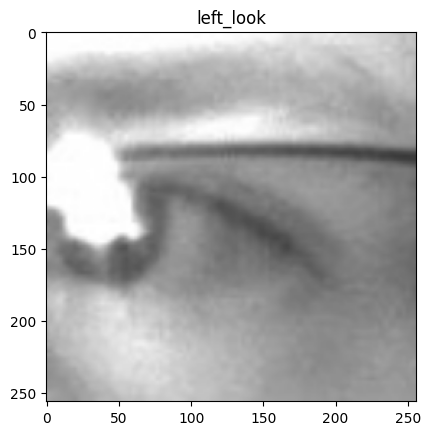

In [6]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    plt.imshow(image_batch[0].numpy().astype("uint8"))
    plt.title(CLASS_NAME[label_batch[0]])
    print(label_batch.numpy())

In [7]:
def get_dataset_partitions(ds, train_split = 0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffleSize=10000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffleSize, seed=12)
    train_size = int(train_split*ds_size)
    val_size = int(val_split*ds_size)
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [8]:
train_ds, val_ds, test_ds = get_dataset_partitions(dataset)
print(len(train_ds),
len(test_ds),
len(val_ds),)

359 46 44


In [9]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)


In [10]:
resizeAndRescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])
dataAugmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)

])

In [11]:
input_shape = (BATCH_SIZE,IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes =4
model = models.Sequential([
    resizeAndRescale,
    dataAugmentation,
    layers.Conv2D(32,(3,3), activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(4, activation = 'relu'),
    layers.Dense(n_classes, activation='softmax')
])
model.build(input_shape=input_shape)

In [12]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [13]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

In [14]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data=val_ds
)

Epoch 1/10
359/359 [==============================] - 1361s 4s/step - loss: 1.3860 - accuracy: 0.2676 - val_loss: 1.3855 - val_accuracy: 0.2692
Epoch 2/10
202/359 [===============>..............] - ETA: 4:03 - loss: 1.3855 - accuracy: 0.2670

KeyboardInterrupt: 

In [ ]:
scores = model.evaluate(test_ds)

13/13 [==============================] - 7s 289ms/step - loss: 0.8396 - accuracy: 0.6803


In [ ]:
scores

[0.8396475315093994, 0.6802884340286255]

In [ ]:
history.params

{'verbose': 1, 'epochs': 10, 'steps': 100}

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history['loss']
val_loss = history.history["val_loss"]

NameError: name 'history' is not defined

Text(0.5, 1.0, 'Training and Validation Loss')

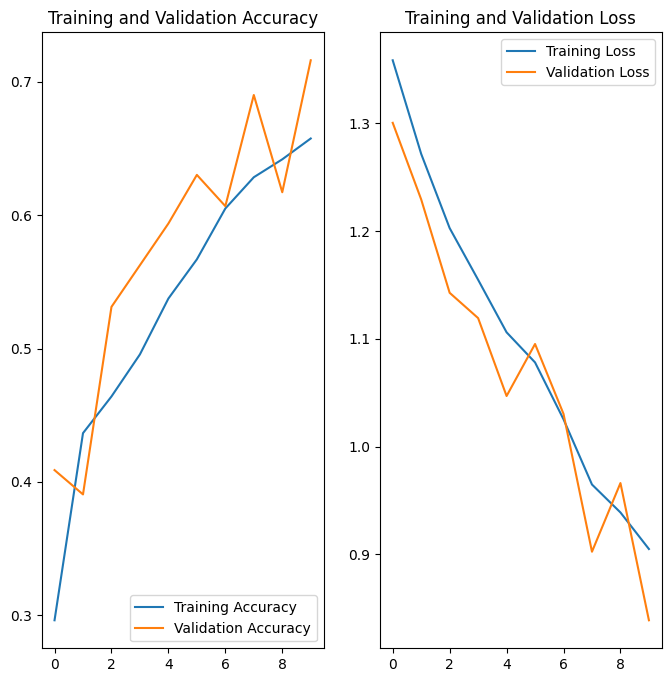

In [ ]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label="Training Accuracy")
plt.plot(range(EPOCHS), val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label="Training Loss")
plt.plot(range(EPOCHS), val_loss, label="Validation Loss")
plt.legend(loc="upper right")
plt.title("Training and Validation Loss")

first image to predict
actual label:  close_look
1/1 [==============================] - 1s 541ms/step
Predicted label:  close_look


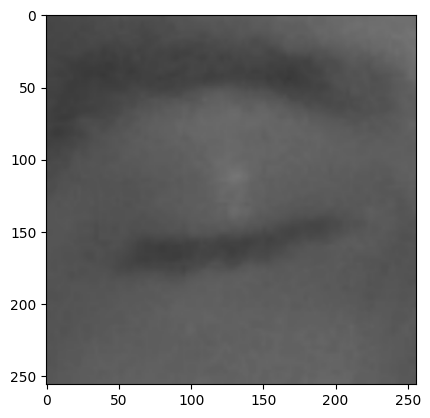

In [ ]:
for images_batch, labels_batch in test_ds.take(1):
    first_image = image_batch[1].numpy().astype(("uint8"))
    first_label = labels_batch[1].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label: ",CLASS_NAME[first_label])
    batch_prediction = model.predict(image_batch)
    print("Predicted label: ",CLASS_NAME[np.argmax(batch_prediction[1])])

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array,0)
    predictions = model.predict(img_array)
    predicted_class = CLASS_NAME[np.argmax(predictions[0])]
    confidence= round(100*(np.max(predictions[0])),2)
    return predicted_class, confidence

1/1 [==============================] - 0s 69ms/step


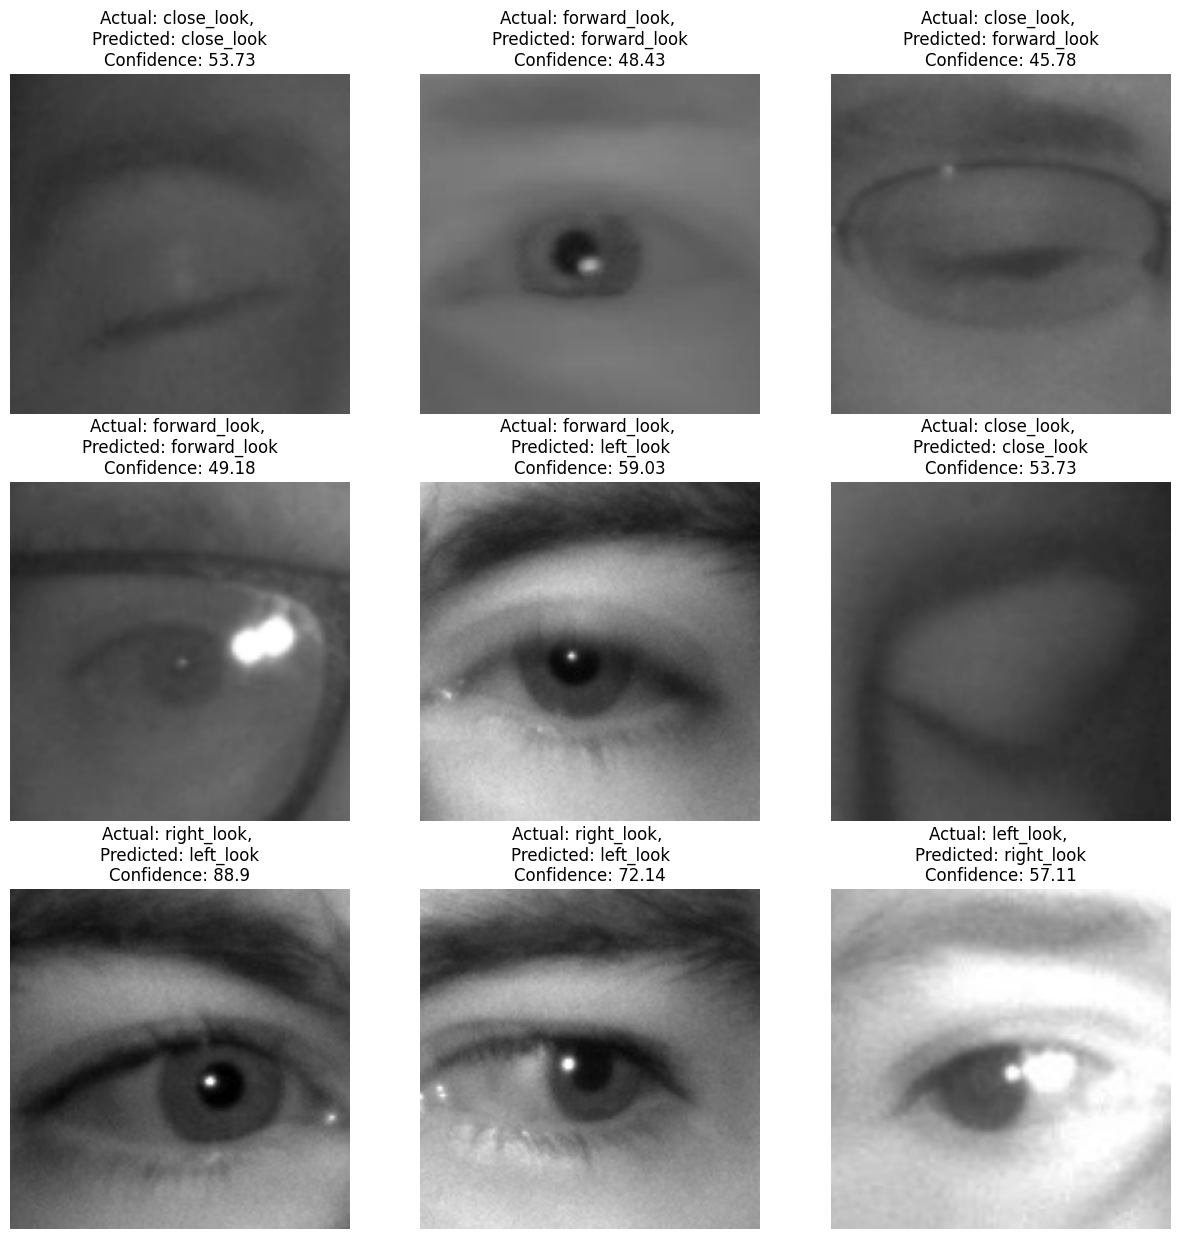

In [ ]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(model,images[i].numpy())
        actual_class = CLASS_NAME[labels[i]]
        plt.title(f"Actual: {actual_class}, \nPredicted: {predicted_class}\nConfidence: {confidence}")
        plt.axis("off")

In [ ]:
model_version = 3
model.save(f"./models/modelV{model_version}.keras")


In [ ]:
import tensorflow as tf

model = tf.keras.models.load_model("models/model.h5")
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 80, 80, 3)]          0         []                            
                                                                                                  
 conv2d_94 (Conv2D)          (None, 39, 39, 32)           864       ['input_2[0][0]']             
                                                                                                  
 batch_normalization_94 (Ba  (None, 39, 39, 32)           96        ['conv2d_94[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_94 (Activation)  (None, 39, 39, 32)           0         ['batch_normalization_94